In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 

import importlib

import os
import sys
sys.path.append("../")
import methods  
importlib.reload(methods)

<module 'methods' from '/Users/timothysudijono/Projects/statistics/empirical_bayes/CompoundWelfareMaximization/notebooks/../methods.py'>

## Introduction

Test two methods for gradient estimation -> integrate them to get estimates of the welfare curve itself.

In [26]:
df = pd.read_csv("../analyses/data/example_te_data.csv").iloc[:,1:]
df["tstats"] = df["treatment_effects"]/df["standard_errors"]
df.head(10)
print(df.shape)

np.random.seed(17)
n = df.shape[0]
true_effects = np.random.normal(0.1,0.05,n)
sigmas = np.array(df["standard_errors"])

(331, 3)


In [41]:
Xs = true_effects + np.random.normal(0,sigmas)


def integrated_surge(Xs, sigmas, lb = -5, ub = 5):

    C_grid = np.linspace(lb, ub, 1000)
    bandwidth = np.sqrt(2*np.log(n))

    def fie(x):
        return np.sin(bandwidth*x)/(np.pi*x)

    def dv_fie(x):
        return (bandwidth*x*np.cos(bandwidth*x) - np.sin(bandwidth*x))/(np.pi*x**2)

    surge_estimate = np.zeros_like(C_grid).astype(float)

    for i in np.arange(len(C_grid)):
        c = C_grid[i]
        
        #F1 = sigmas*dv_fie(Xs/sigmas - c)
        #F2 = Xs*fie(Xs/sigmas - c)

        F1 = sigmas*dv_fie(Xs/sigmas - c)
        F2 = c*sigmas*fie(Xs/sigmas - c)

        surge_estimate[i] = -F1.sum() - F2.sum()

    integrated_surge = cumtrapz(surge_estimate, C_grid, initial=0)
    return integrated_surge


In [42]:
int_surge_estimate = integrated_surge(Xs, sigmas, -10,10)


NUWE Optimal Threshold: 0.020040080160320883
True Optimal Threshold: 0.020040080160320883
-10.0


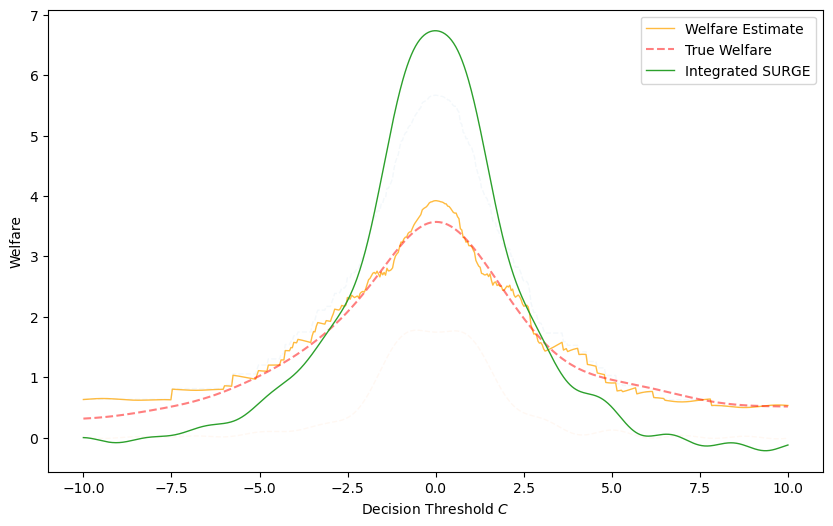

In [43]:
C_grid = np.linspace(-10, 10, 1000)

res = methods.heteroskedastic_normal_welfare_estimator(Xs, sigmas, lb = -10, ub = 10, smoothen_nn=False, true_effects= true_effects, plot = True)

plt.plot(C_grid,int_surge_estimate, linewidth = 1,
         label =  "Integrated SURGE")

plt.legend()
print(C_grid[np.argmax(integrated_surge)])

In [44]:
true_effects = np.random.standard_t(2,n)/50
sigmas = np.array(df["standard_errors"])

mc_runs = 50
assure_welfares = np.zeros(mc_runs).astype(float)
surge_welfares = np.zeros(mc_runs).astype(float)

for j in range(mc_runs):

    Xs = true_effects + np.random.normal(0,sigmas)

    ### assure
    assure_curve = methods.heteroskedastic_normal_welfare_estimator(Xs, sigmas, lb = -10, ub = 5);
    C_grid = np.linspace(-10, 5, 500)
    threshold = C_grid[np.argmax(assure_curve)]
    assure_welfares[j] = true_effects[Xs >= threshold*sigmas].sum()

    ### surge
    surge_welfare_curve = integrated_surge(Xs, sigmas, lb = -10, ub = 5)
    C_grid = np.linspace(-10, 5, 1000)
    threshold = C_grid[np.argmax(surge_welfare_curve)]
    surge_welfares[j] = true_effects[Xs >= threshold*sigmas].sum()


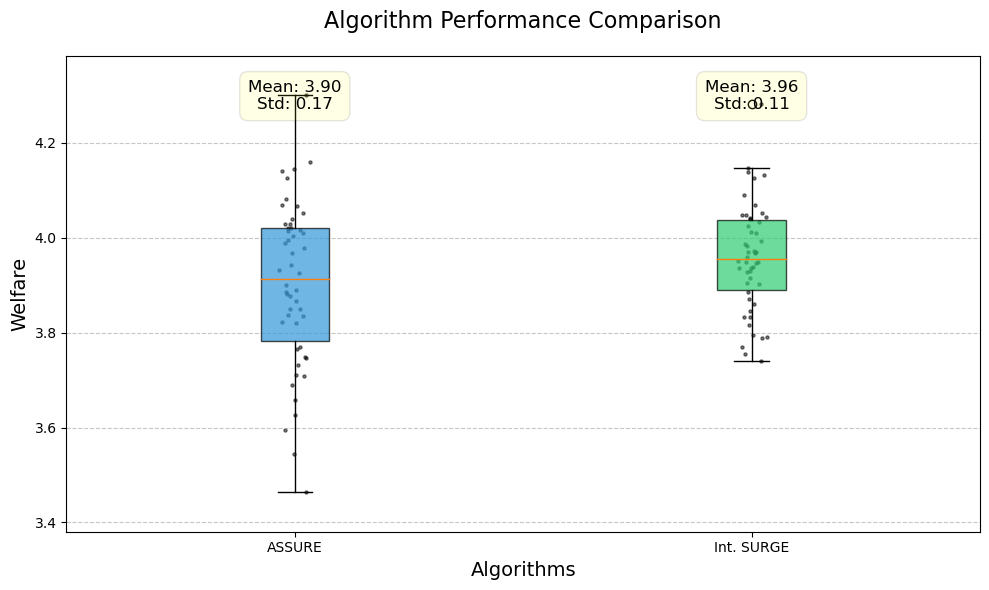

In [45]:
def compare_insample_welfares(welfare1, welfare2, title):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create boxplots
    box_data = [welfare1, welfare2]
    labels = ['ASSURE', 'Int. SURGE']

    # Box plot with customization
    boxplot = ax.boxplot(box_data, patch_artist=True, labels=labels)

    # Customize the boxplots
    colors = ['#3498db', '#2ecc71']
    for box, color in zip(boxplot['boxes'], colors):
        box.set(facecolor=color, alpha=0.7)
        
    # Add a horizontal grid for better readability
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Add labels and title
    ax.set_title('Algorithm Performance Comparison', fontsize=16, pad=20)
    ax.set_ylabel('Welfare', fontsize=14)
    ax.set_xlabel('Algorithms', fontsize=14)

    # Add some padding to y-axis for better visualization
    y_min = min([min(data) for data in box_data])
    y_max = max([max(data) for data in box_data])
    padding = (y_max - y_min) * 0.1
    ax.set_ylim(y_min - padding, y_max + padding)

    # Optional: Add data points
    for i, data in enumerate(box_data):
        # Add a small horizontal jitter to better visualize the points
        x = np.random.normal(i+1, 0.02, size=len(data))
        ax.scatter(x, data, alpha=0.5, s=5, color='black')

    # Add some statistics in the plot
    for i, data in enumerate(box_data):
        stats_text = f"Mean: {np.mean(data):.2f}\nStd: {np.std(data):.2f}"
        ax.annotate(stats_text, xy=(i+1, y_max), xytext=(0, -10),
                    textcoords='offset points', ha='center', fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.1))

    plt.tight_layout()
    #plt.savefig(title, bbox_inches = 'tight')
    plt.show()

compare_insample_welfares(assure_welfares, surge_welfares, title="results/paired_scatter_comparison.pdf")

## Comparison

It's unclear what the comparison is between the two methods. It seems like int. SURGE might be more stable - it's smoother and it has better tail properties.